# 03: Fraud Detection Tutorial - 4-Stage Curriculum Implementation

**Theme:** 開発者が「自分のデータでどう学習させればいいか」を理解するための、コピー＆ペースト可能なレシピブックです。

## What You'll Learn

1. **Dataset Preparation**: Kaggle Credit Card Fraud Detectionデータの準備
2. **System Config**: 不均衡データに対するベストプラクティス設定
3. **4-Stage Curriculum Training**: 各Stageの詳細な解説と実行
4. **Evaluation**: Trust Scoreを使った分析と評価

---

## Architecture Overview

```mermaid
flowchart TB
    subgraph Input
        X["Transaction Features (30 dims)"]
    end

    subgraph Samatha["SamathaEngine (収束エンジン)"]
        Adapter["MlpAdapter"]
        Augmenter["GaussianAugmenter"]
        Vitakka["Vitakka (意図的初期化)"]
        Vicara["Vicara Loop (収束的洗練)<br/>s₁ → s₂ → ... → s*"]
        Santana["SantanaLog (軌跡記録)"]
        
        Adapter --> Augmenter --> Vitakka
        Vitakka -->|"s₀"| Vicara
        Vicara --> Santana
    end

    subgraph Vipassana["VipassanaEngine (メタ認知)"]
        Meta["S* + SantanaLog → V_ctx, α (trust)"]
    end

    subgraph Output
        Decoder["ConditionalDecoder"]
        Result["Fraud/Normal Classification"]
    end

    X --> Adapter
    Santana -->|"S*"| Meta
    Meta --> Decoder
    Decoder --> Result
```

---

## 4-Stage Curriculum Overview

| Stage | Name | Trainable Components | Objective |
|-------|------|---------------------|----------|
| 0 | Adapter Pre-training | Adapter, AdapterReconHead | Reconstruction |
| 1 | Samatha Training | Adapter, Vitakka, Vicara, Sati, SamathaReconHead | Stability + Recon |
| 2 | Vipassana Training | Vipassana | Contrastive (BCE on trust) |
| 3 | Decoder Fine-tuning | ConditionalDecoder | Task-specific |

## 1. Setup & Imports

In [1]:
# Satipatthana Framework Setup
# 1. ログ設定は必ず最初に行う
from satipatthana.utils.logger import setup_logging
setup_logging()

from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import TrainingArguments
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    fbeta_score,
    recall_score,
    precision_score,
)
import warnings
warnings.filterwarnings('ignore')

# Core System
from satipatthana.core.system import SatipatthanaSystem, TrainingStage
from satipatthana.core.engines import SamathaEngine, VipassanaEngine

# Configs
from satipatthana.configs.system import SystemConfig, SamathaConfig, VipassanaEngineConfig
from satipatthana.configs.adapters import MlpAdapterConfig
from satipatthana.configs.decoders import ReconstructionDecoderConfig, ConditionalDecoderConfig
from satipatthana.configs.vitakka import StandardVitakkaConfig
from satipatthana.configs.vicara import StandardVicaraConfig
from satipatthana.configs.vipassana import StandardVipassanaConfig
from satipatthana.configs.augmenter import GaussianNoiseAugmenterConfig
from satipatthana.configs.sati import FixedStepSatiConfig

# Components
from satipatthana.components.adapters.mlp import MlpAdapter
from satipatthana.components.decoders.reconstruction import ReconstructionDecoder
from satipatthana.components.decoders.conditional import ConditionalDecoder
from satipatthana.components.vitakka.standard import StandardVitakka
from satipatthana.components.vicara.standard import StandardVicara
from satipatthana.components.refiners.mlp import MlpRefiner
from satipatthana.components.vipassana.standard import StandardVipassana
from satipatthana.components.augmenters.gaussian import GaussianNoiseAugmenter
from satipatthana.components.sati.fixed_step import FixedStepSati

# Trainer
from satipatthana.train.trainer import SatipatthanaTrainer

# VoidDataset for Stage 2 OOD training
from satipatthana.data import FilteredNoiseVoid

# Device configuration
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device: {device}")

/Users/ryota.ido/mine/samadhi_model/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


## 2. Dataset Preparation

KaggleのCredit Card Fraud Detectionデータセットを使用します。

### データセットの特徴
- 284,807件のトランザクション
- 492件の不正取引（0.172%）→ **極めて不均衡**
- 30個の特徴量（V1-V28: PCA変換済み, Time, Amount）

### Kaggle APIの設定（初回のみ）

1. [Kaggle](https://www.kaggle.com/) にログイン
2. Account Settings → API → "Create New Token" をクリック
3. ダウンロードされた `kaggle.json` を `~/.kaggle/` に配置
4. `chmod 600 ~/.kaggle/kaggle.json` で権限を設定

In [2]:
# ========================================
# Download dataset from Kaggle (if not exists)
# ========================================
# Note: ~/.kaggle/kaggle.json が必要です（上記参照）

DATA_DIR = Path("./data")
CSV_PATH = DATA_DIR / "creditcard.csv"

if not CSV_PATH.exists():
    print("Downloading Credit Card Fraud Detection dataset...")
    !mkdir -p ./data
    !kaggle datasets download -d mlg-ulb/creditcardfraud -p ./data --unzip
else:
    print(f"Dataset already exists at {CSV_PATH}")

Dataset already exists at data/creditcard.csv


In [3]:
# ========================================
# Load and explore data
# ========================================
import pandas as pd
from pathlib import Path

CSV_PATH = Path("./data/creditcard.csv")

print("Loading Credit Card Fraud Detection dataset...")
df = pd.read_csv(CSV_PATH)

print(f"\nDataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['Class'].value_counts())
print(f"\nFraud ratio: {df['Class'].mean() * 100:.3f}%")

# Display first few rows
print(f"\nFeature columns: {list(df.columns)}")
df.head()

Loading Credit Card Fraud Detection dataset...

Dataset shape: (284807, 31)

Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Fraud ratio: 0.173%

Feature columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# ========================================
# Preprocess data
# ========================================

# Separate features and labels
X = df.drop('Class', axis=1).values
y = df['Class'].values

# Standardize features (V1-V28 are already PCA-transformed, but Time/Amount need scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time-series split (NOT random shuffle - avoid data leakage)
# Credit card transactions are time-ordered, so we split by time
# First 80% for training, last 20% for testing
split_idx = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training set: {len(X_train)} samples")
print(f"  - Normal: {(y_train == 0).sum()}")
print(f"  - Fraud:  {(y_train == 1).sum()}")
print(f"  - Fraud ratio: {(y_train == 1).mean() * 100:.3f}%")
print(f"\nTest set: {len(X_test)} samples")
print(f"  - Normal: {(y_test == 0).sum()}")
print(f"  - Fraud:  {(y_test == 1).sum()}")
print(f"  - Fraud ratio: {(y_test == 1).mean() * 100:.3f}%")

INPUT_DIM = X_train.shape[1]
print(f"\nInput dimension: {INPUT_DIM}")

Training set: 227845 samples
  - Normal: 227428
  - Fraud:  417
  - Fraud ratio: 0.183%

Test set: 56962 samples
  - Normal: 56887
  - Fraud:  75
  - Fraud ratio: 0.132%

Input dimension: 30


In [5]:
# ========================================
# Create PyTorch Dataset
# ========================================

class FraudDetectionDataset(Dataset):
    """
    Dataset for Credit Card Fraud Detection.

    Returns dict with:
        x: Feature tensor (for adapter input)
        y: Feature tensor (for reconstruction target)
        class_label: Fraud/Normal label (for classification)
    """
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        return {
            "x": x,              # Input features
            "y": x,              # Reconstruction target (same as input)
            "class_label": self.y[idx]  # Fraud/Normal label
        }


# Create datasets
train_dataset = FraudDetectionDataset(X_train, y_train)
test_dataset = FraudDetectionDataset(X_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Verify dataset format
sample = train_dataset[0]
print("Dataset sample:")
print(f"  x shape: {sample['x'].shape}")
print(f"  y shape: {sample['y'].shape}")
print(f"  class_label: {sample['class_label']}")

Dataset sample:
  x shape: torch.Size([30])
  y shape: torch.Size([30])
  class_label: 0


## 3. Configuration (Best Practice)

不正検知タスクに最適化された設定を行います。

### Key Settings:
- `MlpAdapterConfig`: 30次元の特徴量を潜在空間に変換
- `use_label_guidance=True`: Stage 1でラベル情報を利用して収束を助ける
- `n_probes=8`: 不正パターンと正常パターンの複数クラスタをキャプチャ

In [6]:
# ========================================
# Global Parameters
# ========================================
DIM = 64            # Latent dimension
N_PROBES = 8        # Number of concept probes
MAX_STEPS = 8       # Vicara refinement steps
N_CLASSES = 2       # Binary classification (Normal/Fraud)

# ========================================
# Component Configurations
# ========================================

# Adapter: 30D features -> Latent Vector (dim=64)
adapter_config = MlpAdapterConfig(
    input_dim=INPUT_DIM,
    dim=DIM,
    adapter_hidden_dim=128,
    dropout=0.1
)

# Augmenter: Gaussian noise for regularization
augmenter_config = GaussianNoiseAugmenterConfig(
    max_noise_std=0.5
)

# Vitakka: Semantic initialization via prototype matching
vitakka_config = StandardVitakkaConfig(
    dim=DIM,
    n_probes=N_PROBES,
    probe_trainable=True,
    mix_alpha=0.5,
    softmax_temp=0.2,
    gate_threshold=-1.0  # Always open during training
)

# Vicara: Convergent refinement
vicara_config = StandardVicaraConfig(
    dim=DIM,
    refine_steps=MAX_STEPS,
    inertia=0.3,
)

# Sati: Fixed step stopping
sati_config = FixedStepSatiConfig()

# Vipassana: Meta-cognition with 8 Grounding Metrics
vipassana_config = StandardVipassanaConfig(
    latent_dim=DIM,
    gru_hidden_dim=32,
    metric_proj_dim=32,
    max_steps=MAX_STEPS,
)
CONTEXT_DIM = vipassana_config.context_dim  # Auto-computed

# Task Decoder: S* + V_ctx -> Class logits
task_decoder_config = ConditionalDecoderConfig(
    dim=DIM,
    context_dim=CONTEXT_DIM,
    output_dim=N_CLASSES,
    decoder_hidden_dim=128
)

# Reconstruction Decoders for pre-training
adapter_recon_config = ReconstructionDecoderConfig(
    dim=DIM,
    input_dim=INPUT_DIM,
    decoder_hidden_dim=128
)

samatha_recon_config = ReconstructionDecoderConfig(
    dim=DIM,
    input_dim=INPUT_DIM,
    decoder_hidden_dim=128
)

print("Configuration created!")
print(f"  Input Dim: {INPUT_DIM}")
print(f"  Latent Dim: {DIM}")
print(f"  Max Steps: {MAX_STEPS}")
print(f"  N_Probes: {N_PROBES}")
print(f"  Context Dim: {CONTEXT_DIM}")

Configuration created!
  Input Dim: 30
  Latent Dim: 64
  Max Steps: 8
  N_Probes: 8
  Context Dim: 64


## 4. Build System

In [7]:
def build_system():
    """Build complete SatipatthanaSystem for Fraud Detection."""
    print("Building SatipatthanaSystem...")

    # Components
    adapter = MlpAdapter(adapter_config)
    augmenter = GaussianNoiseAugmenter(augmenter_config)
    vitakka = StandardVitakka(vitakka_config)
    refiner = MlpRefiner({"dim": DIM})
    vicara = StandardVicara(vicara_config, refiner=refiner)
    sati = FixedStepSati(sati_config)
    vipassana_module = StandardVipassana(vipassana_config)
    task_decoder = ConditionalDecoder(task_decoder_config)

    # Reconstruction Heads
    adapter_recon_head = ReconstructionDecoder(adapter_recon_config)
    samatha_recon_head = ReconstructionDecoder(samatha_recon_config)

    # Engine Configs
    samatha_config_obj = SamathaConfig(
        dim=DIM,
        max_steps=MAX_STEPS,
        adapter=adapter_config,
        augmenter=augmenter_config,
        vitakka=vitakka_config,
        vicara=vicara_config,
        sati=sati_config
    )

    vipassana_engine_config = VipassanaEngineConfig(
        vipassana=vipassana_config
    )

    system_config = SystemConfig(
        dim=DIM,
        seed=42,
        use_label_guidance=True,  # Use labels to guide convergence
        samatha=samatha_config_obj,
        vipassana=vipassana_engine_config,
        task_decoder=task_decoder_config
    )

    # Engines
    samatha_engine = SamathaEngine(
        config=samatha_config_obj,
        adapter=adapter,
        augmenter=augmenter,
        vitakka=vitakka,
        vicara=vicara,
        sati=sati
    )

    vipassana_engine = VipassanaEngine(
        config=vipassana_engine_config,
        vipassana=vipassana_module
    )

    # System
    system = SatipatthanaSystem(
        config=system_config,
        samatha=samatha_engine,
        vipassana=vipassana_engine,
        task_decoder=task_decoder,
        adapter_recon_head=adapter_recon_head,
        samatha_recon_head=samatha_recon_head
    )

    print("  SatipatthanaSystem built successfully!")
    return system


system = build_system()
system.to(device)
print(f"  Moved to device: {device}")

# Count parameters
total_params = sum(p.numel() for p in system.parameters())
trainable_params = sum(p.numel() for p in system.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

Building SatipatthanaSystem...
  SatipatthanaSystem built successfully!
  Moved to device: mps
  Total parameters: 140,897
  Trainable parameters: 140,897


## 5. Create Datasets for Stage 2 (Pattern A: Isolation)

Stage 2 (Vipassana Training) では、**Clean**（信頼できるデータ）と**Void**（信頼できないデータ）を区別する能力を学習します。

### Pattern A: Isolation Strategy

[training_strategy.md](../docs/training_strategy.md) に従い、**教師あり異常検知**では以下の設定を使用します：

| Data Type | Target α | 内容 |
|-----------|----------|------|
| **Clean** | 1.0 | Normalデータのみ |
| **Void** | 0.0 | **Fraudラベル** + 合成ノイズ |

### なぜFraudをVoidに入れるのか？

Vipassanaの**Grounding Metrics**（特に`s0_min_dist`, `recon_error`）は、入力が「既知の概念から遠いかどうか」を判定します。

- **Clean = Normalのみ** → Vipassanaは「Normal = 健全な収束」と学習
- **Void = Fraud + Noise** → Vipassanaは「Fraud = 異常な収束」と学習

これにより、Fraudの軌跡を「信頼できない」と判定する能力が身につきます。

### 合成ノイズの役割

Fraudラベルだけでなく合成ノイズも含める理由：
1. **未知の異常への汎化**: 学習時のFraudパターン以外も拒否できるように
2. **OOD検出能力**: 分布外のデータ全般を検出

In [8]:
# ========================================
# Create Datasets for Stage 2 (Pattern A: Isolation)
# ========================================
# Stage 2では Clean=Normal, Void=Fraud+Noise という設定を使用します。
# これにより、VipassanaはFraudの軌跡を「信頼できない」と学習します。

from satipatthana.data import VoidDataset

# ========================================
# 1. Clean Dataset: Normalのみ
# ========================================
normal_mask = y_train == 0
X_normal = X_train[normal_mask]
y_normal = y_train[normal_mask]

# Stage 2用のCleanデータセット
clean_dataset_for_stage2 = FraudDetectionDataset(X_normal, y_normal)

print(f"Clean Dataset (Normal only): {len(clean_dataset_for_stage2)} samples")

# ========================================
# 2. Void Dataset: 動的生成 (Fraud+微小ノイズ + ランダムノイズ)
# ========================================

# Fraudサンプルを準備
fraud_mask = y_train == 1
X_fraud = X_train[fraud_mask]
fraud_tensors = torch.tensor(X_fraud, dtype=torch.float32)

print(f"\nFraud samples for Void generation: {len(fraud_tensors)}")

# 動的生成関数
# - 70%: Fraud + 微小ノイズ → 決定境界の精密化
# - 30%: 完全ランダムノイズ → 堅牢性確保
FRAUD_RATIO = 0.7
FRAUD_NOISE_STD = 0.1   # Fraudへの微小ノイズ
RANDOM_NOISE_STD = 2.0  # ランダムノイズの標準偏差

def generate_mixed_void():
    """Fraud+微小ノイズ と ランダムノイズ を確率的に生成"""
    if torch.rand(1).item() < FRAUD_RATIO:
        # Fraud + 微小ノイズ (決定境界の精密化)
        idx = torch.randint(0, len(fraud_tensors), (1,)).item()
        base = fraud_tensors[idx]
        noise = torch.randn_like(base) * FRAUD_NOISE_STD
        return {"x": base + noise}
    else:
        # 完全ランダムノイズ (堅牢性確保)
        return {"x": torch.randn(INPUT_DIM) * RANDOM_NOISE_STD}

# Void Dataset (動的生成、他Pathと同等のサンプル数)
VOID_LENGTH = 50000  # 他Path (~45,000) と同等
void_dataset = VoidDataset(source=generate_mixed_void, length=VOID_LENGTH)

print(f"\n" + "="*50)
print(f"Stage 2 Dataset Summary (Pattern A: Isolation)")
print(f"="*50)
print(f"Clean (Normal only): {len(clean_dataset_for_stage2):,} samples")
print(f"Void (Dynamic generation): {len(void_dataset):,} samples")
print(f"  - {FRAUD_RATIO*100:.0f}% Fraud + noise (std={FRAUD_NOISE_STD})")
print(f"  - {(1-FRAUD_RATIO)*100:.0f}% Random noise (std={RANDOM_NOISE_STD})")
print(f"\nVoid composition per epoch (expected):")
print(f"  - Fraud-based: ~{int(VOID_LENGTH * FRAUD_RATIO):,} samples")
print(f"  - Random noise: ~{int(VOID_LENGTH * (1-FRAUD_RATIO)):,} samples")
print(f"\nThis follows Pattern A: Isolation strategy from training_strategy.md")
print(f"  - Clean = Normal → Vipassana learns 'Normal = trustworthy'")
print(f"  - Void = Fraud+ε + Noise → Vipassana learns 'Fraud = untrustworthy'")

Clean Dataset (Normal only): 227428 samples

Fraud samples for Void generation: 417

Stage 2 Dataset Summary (Pattern A: Isolation)
Clean (Normal only): 227,428 samples
Void (Dynamic generation): 50,000 samples
  - 70% Fraud + noise (std=0.1)
  - 30% Random noise (std=2.0)

Void composition per epoch (expected):
  - Fraud-based: ~35,000 samples
  - Random noise: ~15,000 samples

This follows Pattern A: Isolation strategy from training_strategy.md
  - Clean = Normal → Vipassana learns 'Normal = trustworthy'
  - Void = Fraud+ε + Noise → Vipassana learns 'Fraud = untrustworthy'


## 6. The Trainer Loop (Step-by-Step)

`SatipatthanaTrainer`を使用して4段階のカリキュラム学習を実行します。

### Stage 0: Adapter Pre-training
- **目的**: Adapterの初期化、入力→潜在空間の変換を学習
- **訓練対象**: `Adapter`, `AdapterReconHead`
- **損失関数**: Reconstruction Loss

### Stage 1: Samatha Training
- **目的**: 収束する不動点を学習
- **訓練対象**: `Adapter`, `Vitakka`, `Vicara`, `Sati`, `SamathaReconHead`
- **損失関数**: Stability Loss + Reconstruction Loss + (Label Guidance)

### Stage 2: Vipassana Training
- **目的**: メタ認知 - 信頼度の学習
- **訓練対象**: `Vipassana`
- **損失関数**: BCE Loss (Clean=高信頼, Drunk/Void=低信頼)

### Stage 3: Decoder Fine-tuning
- **目的**: 最終タスク（不正検知）用のデコーダを学習
- **訓練対象**: `ConditionalDecoder`
- **損失関数**: Cross Entropy Loss

In [9]:
# ========================================
# Create Trainer
# ========================================

# Compute class weights for imbalanced data
# 注意: 極端な重み付け（例: [0.5, 273]）は「迷ったらFraud」と学習させてしまう
# マイルドな重み付けに変更
# class_weights = n_samples / (n_classes * class_counts)  # → [0.5, 273] 極端すぎる
class_weight_tensor = torch.tensor([1.0, 10.0], dtype=torch.float32).to(device)
print(f"Class weights: Normal={class_weight_tensor[0]:.1f}, Fraud={class_weight_tensor[1]:.1f}")
print("  (Mild weighting to avoid 'predict Fraud when in doubt' behavior)")

training_args = TrainingArguments(
    output_dir="./outputs/03_fraud_detection",
    num_train_epochs=1,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    logging_steps=200,
    remove_unused_columns=False,
    label_names=["y", "class_label"],
    report_to="none",
    save_strategy="no",
)

trainer = SatipatthanaTrainer(
    model=system,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    stage=TrainingStage.ADAPTER_PRETRAINING,
    task_type="classification",
    use_label_guidance=True,
    noise_level=0.3,
    stability_weight=0.1,
    guidance_weight=5.0,
    recon_weight=1.0,
    diversity_weight=0.5,
    label_key="class_label",
    void_dataset=void_dataset,  # For Stage 2
    class_weight=class_weight_tensor,  # Mild weighting for Stage 3
)

print("\nSatipatthanaTrainer created!")
print(f"  - void_dataset: Dynamic generation ({len(void_dataset)} virtual samples)")
print(f"  - use_label_guidance: True")
print(f"  - task_type: classification")
print(f"  - class_weight: [1.0, 10.0] (mild weighting)")

Class weights: Normal=1.0, Fraud=10.0
  (Mild weighting to avoid 'predict Fraud when in doubt' behavior)
[2025-12-12 16:31:27] INFO [satipatthana.core.system] Training stage set to: ADAPTER_PRETRAINING
[2025-12-12 16:31:27] INFO [satipatthana.train.trainer] Stage ADAPTER_PRETRAINING: Trainable components: ['adapter', 'adapter_recon_head']
[2025-12-12 16:31:27] INFO [satipatthana.train.trainer] Initialized SatipatthanaTrainer for stage: ADAPTER_PRETRAINING

SatipatthanaTrainer created!
  - void_dataset: Dynamic generation (50000 virtual samples)
  - use_label_guidance: True
  - task_type: classification
  - class_weight: [1.0, 10.0] (mild weighting)


In [10]:
# ========================================
# Stage 0: Adapter Pre-training
# ========================================
print("="*60)
print("Stage 0: Adapter Pre-training")
print("="*60)
print("Objective: Learn input -> latent space transformation")
print("Trainable: Adapter, AdapterReconHead")
print("Loss: Reconstruction Loss")
print()

trainer.train_stage(TrainingStage.ADAPTER_PRETRAINING, num_epochs=5)

Stage 0: Adapter Pre-training
Objective: Learn input -> latent space transformation
Trainable: Adapter, AdapterReconHead
Loss: Reconstruction Loss

[2025-12-12 16:31:27] INFO [satipatthana.core.system] Training stage set to: ADAPTER_PRETRAINING
[2025-12-12 16:31:27] INFO [satipatthana.train.trainer] Stage ADAPTER_PRETRAINING: Trainable components: ['adapter', 'adapter_recon_head']
[2025-12-12 16:31:27] INFO [satipatthana.train.trainer] Starting ADAPTER_PRETRAINING training for 5 epochs


Step,Training Loss
200,0.829200
400,0.615300
600,0.455500
800,0.421500
1000,0.356600
1200,0.362000
1400,0.307500
1600,0.259600
1800,0.263300
2000,0.253100


TrainOutput(global_step=4455, training_loss=0.30198883480495875, metrics={'train_runtime': 18.8572, 'train_samples_per_second': 60413.213, 'train_steps_per_second': 236.249, 'total_flos': 0.0, 'train_loss': 0.30198883480495875, 'epoch': 5.0})

In [11]:
# ========================================
# Stage 1: Samatha Training
# ========================================
print("="*60)
print("Stage 1: Samatha Training")
print("="*60)
print("Objective: Learn converging fixed points")
print("Trainable: Adapter, Vitakka, Vicara, Sati, SamathaReconHead")
print("Loss: Stability + Reconstruction + Label Guidance")
print()

trainer.train_stage(TrainingStage.SAMATHA_TRAINING, num_epochs=10)

Stage 1: Samatha Training
Objective: Learn converging fixed points
Trainable: Adapter, Vitakka, Vicara, Sati, SamathaReconHead
Loss: Stability + Reconstruction + Label Guidance

[2025-12-12 16:31:46] INFO [satipatthana.core.system] Training stage set to: SAMATHA_TRAINING
[2025-12-12 16:31:46] INFO [satipatthana.train.trainer] Stage SAMATHA_TRAINING: Trainable components: ['adapter', 'vitakka', 'vicara', 'samatha_recon_head']
[2025-12-12 16:31:46] INFO [satipatthana.train.trainer] Starting SAMATHA_TRAINING training for 10 epochs


Step,Training Loss
200,0.922000
400,0.878200
600,0.777100
800,0.760400
1000,0.689300
1200,0.697600
1400,0.636100
1600,0.585900
1800,0.588300
2000,0.570500


TrainOutput(global_step=8910, training_loss=0.5050159518566196, metrics={'train_runtime': 114.88, 'train_samples_per_second': 19833.299, 'train_steps_per_second': 77.559, 'total_flos': 0.0, 'train_loss': 0.5050159518566196, 'epoch': 10.0})

In [12]:
# ========================================
# Stage 2: Vipassana Training (Pattern A: Isolation)
# ========================================
print("="*60)
print("Stage 2: Vipassana Training (Pattern A: Isolation)")
print("="*60)
print("Objective: Learn meta-cognition (trust score)")
print("Trainable: Vipassana")
print("Loss: BCE (Clean=high trust, Void=low trust)")
print()
print("Pattern A: Isolation Strategy:")
print("  - Clean Dataset: Normal only → Target: 1.0 (high trust)")
print("  - Void Dataset:  Fraud + Noise → Target: 0.0 (low trust)")
print()
print("Training paths:")
print("  1. Clean Path:     Normal samples → Target: 1.0")
print("  2. Augmented Path: Normal + noise → Target: 1.0 - severity")
print("  3. Drunk Path:     Internal noise → Target: 0.0")
print("  4. Mismatch Path:  Shuffled      → Target: 0.0")
print("  5. Void Path:      Fraud + OOD   → Target: 0.0")
print()

# ========================================
# CRITICAL: Switch to Clean dataset (Normal only) for Stage 2
# ========================================
print("Switching train_dataset to Clean (Normal only)...")
trainer.train_dataset = clean_dataset_for_stage2  # Normal only
trainer.void_dataset = void_dataset  # Fraud + Noise

print(f"  - Clean samples: {len(trainer.train_dataset):,}")
print(f"  - Void samples:  {len(trainer.void_dataset):,}")
print()

# Increase learning rate for Stage 2
original_lr = trainer.args.learning_rate
trainer.args.learning_rate = 1e-2

trainer.train_stage(TrainingStage.VIPASSANA_TRAINING, num_epochs=5)

trainer.args.learning_rate = original_lr

# ========================================
# Restore full dataset for Stage 3
# ========================================
print("\nRestoring train_dataset to full data for Stage 3...")
trainer.train_dataset = train_dataset  # All data (Normal + Fraud)

Stage 2: Vipassana Training (Pattern A: Isolation)
Objective: Learn meta-cognition (trust score)
Trainable: Vipassana
Loss: BCE (Clean=high trust, Void=low trust)

Pattern A: Isolation Strategy:
  - Clean Dataset: Normal only → Target: 1.0 (high trust)
  - Void Dataset:  Fraud + Noise → Target: 0.0 (low trust)

Training paths:
  1. Clean Path:     Normal samples → Target: 1.0
  2. Augmented Path: Normal + noise → Target: 1.0 - severity
  3. Drunk Path:     Internal noise → Target: 0.0
  4. Mismatch Path:  Shuffled      → Target: 0.0
  5. Void Path:      Fraud + OOD   → Target: 0.0

Switching train_dataset to Clean (Normal only)...
  - Clean samples: 227,428
  - Void samples:  50,000

[2025-12-12 16:33:41] INFO [satipatthana.train.trainer] Vipassana networks initialized via forward pass
[2025-12-12 16:33:41] INFO [satipatthana.core.system] Training stage set to: VIPASSANA_TRAINING
[2025-12-12 16:33:41] INFO [satipatthana.train.trainer] Stage VIPASSANA_TRAINING: Trainable components: ['v

Step,Training Loss
200,1.266400
400,0.933600
600,0.867900
800,0.842100
1000,0.827300
1200,0.809700
1400,0.802300
1600,0.795200
1800,0.787000
2000,0.782900



Restoring train_dataset to full data for Stage 3...


In [13]:
# ========================================
# Stage 3: Decoder Fine-tuning
# ========================================
print("="*60)
print("Stage 3: Decoder Fine-tuning")
print("="*60)
print("Objective: Learn task-specific (Fraud Detection) decoder")
print("Trainable: ConditionalDecoder")
print("Loss: Cross Entropy")
print()

trainer.train_stage(TrainingStage.DECODER_FINETUNING, num_epochs=5)

# Set to inference mode
system.set_stage(TrainingStage.INFERENCE)
print()
print("="*60)
print("Training complete!")
print("="*60)

Stage 3: Decoder Fine-tuning
Objective: Learn task-specific (Fraud Detection) decoder
Trainable: ConditionalDecoder
Loss: Cross Entropy

[2025-12-12 16:37:53] INFO [satipatthana.core.system] Training stage set to: DECODER_FINETUNING
[2025-12-12 16:37:53] INFO [satipatthana.train.trainer] Stage DECODER_FINETUNING: Trainable components: ['task_decoder']
[2025-12-12 16:37:53] INFO [satipatthana.train.trainer] Starting DECODER_FINETUNING training for 5 epochs


Step,Training Loss
200,0.190500
400,0.138300
600,0.134000
800,0.133300
1000,0.131400
1200,0.133000
1400,0.134900
1600,0.133100
1800,0.131000
2000,0.134200


[2025-12-12 16:38:44] INFO [satipatthana.core.system] Training stage set to: INFERENCE

Training complete!


### Alternative: Run Full Curriculum at Once

上記のステップを一括で実行することもできます：

In [14]:
# # Alternative: Run full curriculum
# results = trainer.run_curriculum(
#     stage0_epochs=5,
#     stage1_epochs=10,
#     stage2_epochs=5,
#     stage3_epochs=5,
# )

## 7. Evaluation: Two-Stage Approach

学習したモデルを評価します。**2段構えアプローチ**を採用します。

### Three Output Scores

SatipatthanaSystemは3つの異なるスコアを出力します：

| Score | Description | Source |
|-------|-------------|--------|
| `trust_score` | OOD detection score | Static grounding metrics (s0_min_dist, recon_error, etc.) |
| `conformity_score` | Trajectory anomaly score | Dynamic context only (GRU over trajectory) |
| `confidence_score` | Comprehensive score | Static + Dynamic combined |

### Two Threshold Selection Methods

**Method 1: Percentile-based (Recommended for generalization)**
- Normalデータのパーセンタイルから閾値を決定
- Fraudラベルに依存しないため、未知の異常にも汎化しやすい
- 例: Normal 5th percentile → その値以下を「異常」とみなす

**Method 2: F2 Score Maximization (Recommended for known threats)**
- F2スコア（Recall重視）を最大化する閾値を探索
- 既知のFraudパターンに対して最適化

### Why trust_score is Primary

Pattern A (Isolation) では、FraudがVoidとして学習されるため、`trust_score`（静的メトリクス）が最も直接的にFraudを検出します。

- `trust_score`低い → 入力がNormalの既知パターンから遠い（Void的）
- `conformity_score`低い → 収束軌跡が異常
- `confidence_score`低い → 総合的に疑わしい

### Two-Stage Detection Strategy

```
全トランザクション
    ↓ Stage 1: Trust Score Filter
    ↓ (trust_score < threshold → "要注意")
低Trustサンプル（Fraud候補）
    ↓ Stage 2: Decoder Classification
最終判定: Fraud / Normal
```

**利点:**
1. **効率化**: 高Trust = 自動パス、低Trustのみ精査
2. **説明可能性**: 各Scoreで「なぜ要注意か」が分かる

In [15]:
# ========================================
# Inference Function
# ========================================

def get_all_scores_and_predictions(system, data_loader, device):
    """Get all scores and predictions for a dataset.

    Returns:
        dict with:
            - predictions: class predictions
            - fraud_probs: probability of fraud class
            - labels: ground truth labels
            - trust_score: OOD detection score (0-1, higher = more trustworthy)
            - conformity_score: trajectory conformity (0-1, higher = more normal trajectory)
            - confidence_score: comprehensive score (0-1, static + dynamic)
    """
    system.eval()

    all_preds = []
    all_probs = []
    all_labels = []
    all_trust_scores = []
    all_conformity_scores = []
    all_confidence_scores = []

    with torch.no_grad():
        for batch in data_loader:
            x = batch["x"].to(device)
            labels = batch["class_label"].to(device)

            result = system(x, noise_level=0.0)

            # Get predictions
            logits = result.output
            probs = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu())
            all_probs.append(probs[:, 1].cpu())  # Fraud probability
            all_labels.append(labels.cpu())
            all_trust_scores.append(result.trust_score.cpu())
            all_conformity_scores.append(result.conformity_score.cpu())
            all_confidence_scores.append(result.confidence_score.cpu())

    return {
        "predictions": torch.cat(all_preds).numpy(),
        "fraud_probs": torch.cat(all_probs).numpy(),
        "labels": torch.cat(all_labels).numpy(),
        "trust_score": torch.cat(all_trust_scores).numpy().squeeze(),
        "conformity_score": torch.cat(all_conformity_scores).numpy().squeeze(),
        "confidence_score": torch.cat(all_confidence_scores).numpy().squeeze(),
    }


# ========================================
# Get Scores on Train and Test Data
# ========================================
print("="*60)
print("Step 1: Collecting Scores")
print("="*60)

train_results = get_all_scores_and_predictions(system, train_loader, device)
test_results = get_all_scores_and_predictions(system, test_loader, device)

print("\nScore Statistics (Train):")
print(f"  trust_score:      mean={train_results['trust_score'].mean():.4f}, std={train_results['trust_score'].std():.4f}")
print(f"  conformity_score: mean={train_results['conformity_score'].mean():.4f}, std={train_results['conformity_score'].std():.4f}")
print(f"  confidence_score: mean={train_results['confidence_score'].mean():.4f}, std={train_results['confidence_score'].std():.4f}")

print("\nScore Statistics (Test):")
print(f"  trust_score:      mean={test_results['trust_score'].mean():.4f}, std={test_results['trust_score'].std():.4f}")
print(f"  conformity_score: mean={test_results['conformity_score'].mean():.4f}, std={test_results['conformity_score'].std():.4f}")
print(f"  confidence_score: mean={test_results['confidence_score'].mean():.4f}, std={test_results['confidence_score'].std():.4f}")

# ========================================
# Step 2: Threshold Selection Methods
# ========================================
print("\n" + "="*60)
print("Step 2: Threshold Selection")
print("="*60)

score_names = ["trust_score", "conformity_score", "confidence_score"]
best_thresholds = {}

# ----------------------------------------
# Method 1: Percentile-based (Normal distribution)
# ----------------------------------------
print("\n" + "-"*60)
print("Method 1: Percentile-based Threshold (using Normal data only)")
print("-"*60)
print("Threshold = Normal data's Nth percentile (samples below are flagged)")
print()

for score_name in score_names:
    normal_scores = train_results[score_name][train_results["labels"] == 0]

    # Try different percentiles
    for pct in [1, 5, 10]:
        threshold = np.percentile(normal_scores, pct)
        preds = (train_results[score_name] < threshold).astype(int)
        f2 = fbeta_score(train_results["labels"], preds, beta=2, zero_division=0)
        recall = recall_score(train_results["labels"], preds, zero_division=0)
        precision = precision_score(train_results["labels"], preds, zero_division=0)

        if pct == 5:  # Store 5th percentile as default
            best_thresholds[f"{score_name}_pct5"] = threshold

        print(f"  {score_name:<20} {pct:>2}th pct: th={threshold:.4f}, F2={f2:.4f}, Recall={recall:.4f}, Prec={precision:.4f}")

# ----------------------------------------
# Method 2: F2 Score Maximization (per score)
# ----------------------------------------
print("\n" + "-"*60)
print("Method 2: F2 Score Maximization (per score type)")
print("-"*60)
print("Find threshold that maximizes F2 score (Recall-weighted)")
print()

thresholds_to_try = np.linspace(0.1, 0.95, 50)

for score_name in score_names:
    best_f2, best_th = 0, 0.5

    for th in thresholds_to_try:
        preds = (train_results[score_name] < th).astype(int)
        f2 = fbeta_score(train_results["labels"], preds, beta=2, zero_division=0)
        if f2 > best_f2:
            best_f2, best_th = f2, th

    # Compute metrics at best threshold
    best_preds = (train_results[score_name] < best_th).astype(int)
    recall = recall_score(train_results["labels"], best_preds, zero_division=0)
    precision = precision_score(train_results["labels"], best_preds, zero_division=0)

    best_thresholds[f"{score_name}_f2"] = best_th

    print(f"  {score_name:<20}: th={best_th:.4f}, F2={best_f2:.4f}, Recall={recall:.4f}, Prec={precision:.4f}")

# ----------------------------------------
# Summary: Best Thresholds
# ----------------------------------------
print("\n" + "-"*60)
print("Threshold Summary")
print("-"*60)
print(f"{'Score':<20} {'Pct5':<10} {'F2-opt':<10}")
print("-"*40)
for score_name in score_names:
    pct5_th = best_thresholds.get(f"{score_name}_pct5", 0)
    f2_th = best_thresholds.get(f"{score_name}_f2", 0)
    print(f"{score_name:<20} {pct5_th:<10.4f} {f2_th:<10.4f}")

# Use F2-optimized threshold for confidence_score as primary
best_threshold = best_thresholds["confidence_score_f2"]
print(f"\n** Primary threshold (confidence_score, F2-optimized): {best_threshold:.4f} **")

Step 1: Collecting Scores

Score Statistics (Train):
  trust_score:      mean=0.7680, std=0.1681
  conformity_score: mean=0.5159, std=0.1674
  confidence_score: mean=0.8258, std=0.2119

Score Statistics (Test):
  trust_score:      mean=0.7507, std=0.1693
  conformity_score: mean=0.5091, std=0.1637
  confidence_score: mean=0.7971, std=0.2105

Step 2: Threshold Selection

------------------------------------------------------------
Method 1: Percentile-based Threshold (using Normal data only)
------------------------------------------------------------
Threshold = Normal data's Nth percentile (samples below are flagged)

  trust_score           1th pct: th=0.0363, F2=0.3425, Recall=0.6954, Prec=0.1131
  trust_score           5th pct: th=0.4086, F2=0.1351, Recall=0.8681, Prec=0.0309
  trust_score          10th pct: th=0.5787, F2=0.0762, Recall=0.9065, Prec=0.0163
  conformity_score      1th pct: th=0.0074, F2=0.4012, Recall=0.8249, Prec=0.1313
  conformity_score      5th pct: th=0.0779, F

Score Statistics by Class

--- trust_score ---
TRAIN:
  Normal (n=227,428): mean=0.7691, std=0.1656
  Fraud  (n=417):  mean=0.1186, std=0.2387
  Separation: 0.6506
TEST:
  Normal (n=56,887): mean=0.7515, std=0.1678
  Fraud  (n=75):  mean=0.1580, std=0.2572
  Separation: 0.5934

--- conformity_score ---
TRAIN:
  Normal (n=227,428): mean=0.5168, std=0.1663
  Fraud  (n=417):  mean=0.0510, std=0.1434
  Separation: 0.4658
TEST:
  Normal (n=56,887): mean=0.5096, std=0.1629
  Fraud  (n=75):  mean=0.1050, std=0.2142
  Separation: 0.4046

--- confidence_score ---
TRAIN:
  Normal (n=227,428): mean=0.8271, std=0.2094
  Fraud  (n=417):  mean=0.0646, std=0.1917
  Separation: 0.7625
TEST:
  Normal (n=56,887): mean=0.7980, std=0.2090
  Fraud  (n=75):  mean=0.1578, std=0.3224
  Separation: 0.6402


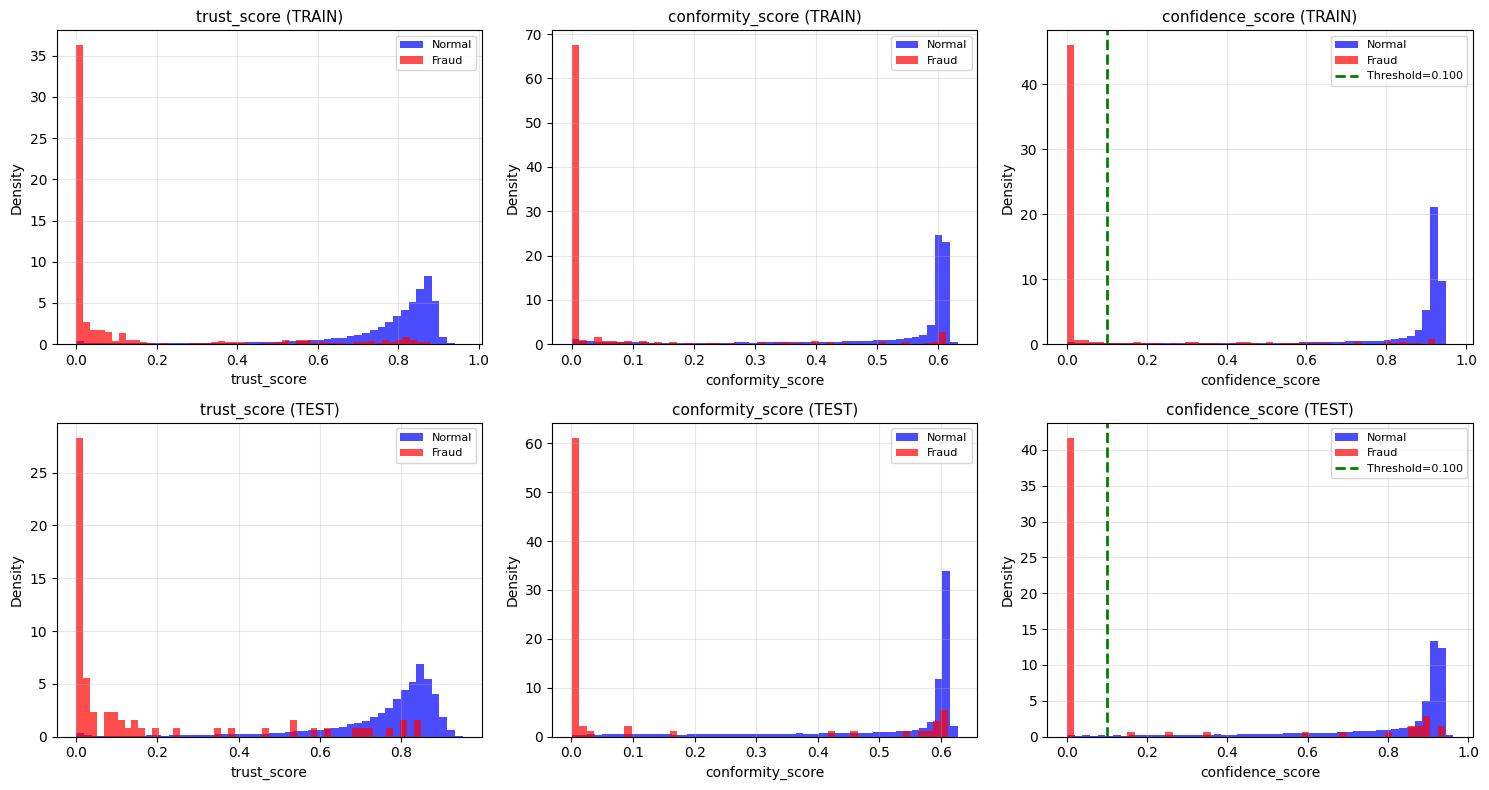


Cohen's d (Effect Size) - Separation Quality

Score                Train d      Test d       Interpretation      
----------------------------------------------------------------
trust_score          3.167        2.733        Large ✓             
conformity_score     3.000        2.126        Large ✓             
confidence_score     3.799        2.356        Large ✓             
----------------------------------------------------------------

Interpretation guide:
  d < 0.2: Negligible (score not useful)
  d = 0.2-0.5: Small separation
  d = 0.5-0.8: Medium separation
  d > 0.8: Large separation (effective)


In [16]:
# ========================================
# Score Statistics by Class (Train vs Test)
# ========================================

def compute_score_stats(results, score_name):
    """Compute statistics for a score by class."""
    normal_scores = results[score_name][results["labels"] == 0]
    fraud_scores = results[score_name][results["labels"] == 1]
    return normal_scores, fraud_scores

print("="*60)
print("Score Statistics by Class")
print("="*60)

score_names = ["trust_score", "conformity_score", "confidence_score"]

for score_name in score_names:
    train_normal, train_fraud = compute_score_stats(train_results, score_name)
    test_normal, test_fraud = compute_score_stats(test_results, score_name)

    print(f"\n--- {score_name} ---")
    print(f"TRAIN:")
    print(f"  Normal (n={len(train_normal):,}): mean={train_normal.mean():.4f}, std={train_normal.std():.4f}")
    print(f"  Fraud  (n={len(train_fraud):,}):  mean={train_fraud.mean():.4f}, std={train_fraud.std():.4f}")
    print(f"  Separation: {train_normal.mean() - train_fraud.mean():.4f}")
    print(f"TEST:")
    print(f"  Normal (n={len(test_normal):,}): mean={test_normal.mean():.4f}, std={test_normal.std():.4f}")
    print(f"  Fraud  (n={len(test_fraud):,}):  mean={test_fraud.mean():.4f}, std={test_fraud.std():.4f}")
    print(f"  Separation: {test_normal.mean() - test_fraud.mean():.4f}")

# ========================================
# Score Distribution Plot (3 scores comparison)
# ========================================

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, score_name in enumerate(score_names):
    train_normal, train_fraud = compute_score_stats(train_results, score_name)
    test_normal, test_fraud = compute_score_stats(test_results, score_name)

    # Train row
    ax = axes[0, idx]
    ax.hist(train_normal, bins=50, alpha=0.7, label=f'Normal', density=True, color='blue')
    ax.hist(train_fraud, bins=50, alpha=0.7, label=f'Fraud', density=True, color='red')
    if score_name == "confidence_score":
        ax.axvline(x=best_threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold={best_threshold:.3f}')
    ax.set_xlabel(score_name, fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(f'{score_name} (TRAIN)', fontsize=11)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Test row
    ax = axes[1, idx]
    ax.hist(test_normal, bins=50, alpha=0.7, label=f'Normal', density=True, color='blue')
    ax.hist(test_fraud, bins=50, alpha=0.7, label=f'Fraud', density=True, color='red')
    if score_name == "confidence_score":
        ax.axvline(x=best_threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold={best_threshold:.3f}')
    ax.set_xlabel(score_name, fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(f'{score_name} (TEST)', fontsize=11)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# Cohen's d (Effect Size) Comparison
# ========================================
print("\n" + "="*60)
print("Cohen's d (Effect Size) - Separation Quality")
print("="*60)

def compute_cohens_d(normal_scores, fraud_scores):
    separation = normal_scores.mean() - fraud_scores.mean()
    pooled_std = np.sqrt((normal_scores.std()**2 + fraud_scores.std()**2) / 2)
    return separation / pooled_std if pooled_std > 0 else 0

print(f"\n{'Score':<20} {'Train d':<12} {'Test d':<12} {'Interpretation':<20}")
print("-"*64)

for score_name in score_names:
    train_normal, train_fraud = compute_score_stats(train_results, score_name)
    test_normal, test_fraud = compute_score_stats(test_results, score_name)

    train_d = compute_cohens_d(train_normal, train_fraud)
    test_d = compute_cohens_d(test_normal, test_fraud)

    if test_d > 0.8:
        interp = "Large ✓"
    elif test_d > 0.5:
        interp = "Medium"
    elif test_d > 0.2:
        interp = "Small"
    else:
        interp = "Negligible ⚠️"

    print(f"{score_name:<20} {train_d:<12.3f} {test_d:<12.3f} {interp:<20}")

print("-"*64)
print("\nInterpretation guide:")
print("  d < 0.2: Negligible (score not useful)")
print("  d = 0.2-0.5: Small separation")
print("  d = 0.5-0.8: Medium separation")
print("  d > 0.8: Large separation (effective)")

## 8. Two-Stage Evaluation Results

### Stage 1: Confidence Score Filter

`confidence_score`（総合スコア）を使って「要注意」サンプルをフィルタリングします。

**3つのスコアの使い分け:**
- `trust_score`: OOD検出に特化（入力が既知パターンからどれだけ離れているか）
- `conformity_score`: 軌跡異常検出に特化（収束過程が正常かどうか）
- `confidence_score`: 上記を統合した総合判定（**推奨**）

In [17]:
# ========================================
# Stage 1: Trust Score Filter Results
# ========================================

# Use trust_score as primary (Pattern A: Isolation)
primary_score = "confidence_score"
primary_threshold = best_thresholds[f"{primary_score}_f2"]

low_trust_mask = test_results[primary_score] < primary_threshold
high_trust_mask = ~low_trust_mask

print("="*60)
print("Stage 1: Trust Score Filter Results")
print("="*60)
print(f"Primary Score: {primary_score}")
print(f"Threshold (F2-optimized): {primary_threshold:.4f}")
print()

# High Trust (Auto-pass)
high_trust_labels = test_results["labels"][high_trust_mask]
print(f"High Trust (Auto-pass): {high_trust_mask.sum():,} samples ({high_trust_mask.mean()*100:.1f}%)")
print(f"  - Actual Normal: {(high_trust_labels == 0).sum():,}")
print(f"  - Actual Fraud:  {(high_trust_labels == 1).sum():,} (missed)")

# Low Trust (Flagged)
low_trust_labels = test_results["labels"][low_trust_mask]
print(f"\nLow Trust (Flagged): {low_trust_mask.sum():,} samples ({low_trust_mask.mean()*100:.1f}%)")
print(f"  - Actual Normal: {(low_trust_labels == 0).sum():,}")
print(f"  - Actual Fraud:  {(low_trust_labels == 1).sum():,}")

# Fraud capture rate
total_fraud = (test_results["labels"] == 1).sum()
captured_fraud = (low_trust_labels == 1).sum()
fraud_capture_rate = captured_fraud / total_fraud if total_fraud > 0 else 0
print(f"\nFraud Capture Rate: {fraud_capture_rate*100:.1f}% ({captured_fraud}/{total_fraud})")

# Enrichment
overall_fraud_ratio = (test_results["labels"] == 1).mean()
flagged_fraud_ratio = (low_trust_labels == 1).mean() if len(low_trust_labels) > 0 else 0
enrichment = flagged_fraud_ratio / overall_fraud_ratio if overall_fraud_ratio > 0 else 0
print(f"Fraud Enrichment: {enrichment:.1f}x (from {overall_fraud_ratio*100:.2f}% to {flagged_fraud_ratio*100:.2f}%)")

Stage 1: Trust Score Filter Results
Primary Score: confidence_score
Threshold (F2-optimized): 0.1000

High Trust (Auto-pass): 56,012 samples (98.3%)
  - Actual Normal: 55,996
  - Actual Fraud:  16 (missed)

Low Trust (Flagged): 950 samples (1.7%)
  - Actual Normal: 891
  - Actual Fraud:  59

Fraud Capture Rate: 78.7% (59/75)
Fraud Enrichment: 47.2x (from 0.13% to 6.21%)


Stage 2: Decoder Classification on Flagged Samples

Classification Report (Flagged Samples Only):
              precision    recall  f1-score   support

      Normal       1.00      0.93      0.97       891
       Fraud       0.50      0.98      0.66        59

    accuracy                           0.94       950
   macro avg       0.75      0.96      0.81       950
weighted avg       0.97      0.94      0.95       950

Confusion Matrix (Flagged Samples Only):
[[833  58]
 [  1  58]]


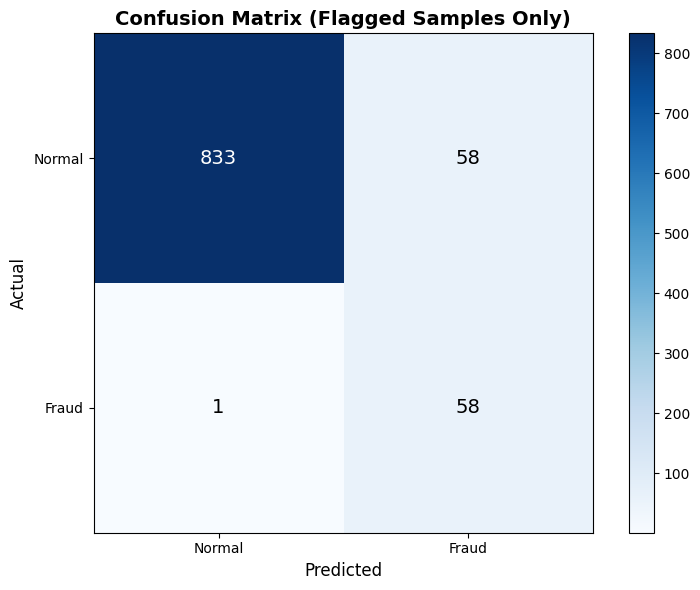

In [18]:
# ========================================
# Stage 2: Decoder Classification on Flagged Samples
# ========================================

print("="*60)
print("Stage 2: Decoder Classification on Flagged Samples")
print("="*60)

# Get decoder predictions for flagged samples only
flagged_predictions = test_results["predictions"][low_trust_mask]
flagged_labels = test_results["labels"][low_trust_mask]

if len(flagged_labels) > 0:
    print("\nClassification Report (Flagged Samples Only):")
    print(classification_report(
        flagged_labels,
        flagged_predictions,
        target_names=["Normal", "Fraud"],
        zero_division=0
    ))

    # Confusion Matrix for flagged samples
    cm = confusion_matrix(flagged_labels, flagged_predictions)

    print("Confusion Matrix (Flagged Samples Only):")
    print(cm)

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, cmap='Blues')

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Normal', 'Fraud'])
    ax.set_yticklabels(['Normal', 'Fraud'])
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f'{cm[i, j]:,}',
                           ha='center', va='center', fontsize=14,
                           color='white' if cm[i, j] > cm.max()/2 else 'black')

    plt.colorbar(im, ax=ax)
    plt.title('Confusion Matrix (Flagged Samples Only)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No samples flagged!")

In [19]:
# ========================================
# Final Two-Stage Results Summary
# ========================================

print("="*60)
print("Two-Stage Detection Summary")
print("="*60)

# Combined predictions: High trust → Normal, Low trust → use decoder
final_predictions = np.zeros_like(test_results["labels"])
final_predictions[high_trust_mask] = 0  # High trust → Normal
final_predictions[low_trust_mask] = test_results["predictions"][low_trust_mask]  # Low trust → Decoder

print("\nFinal Classification Report (Two-Stage):")
print(classification_report(
    test_results["labels"],
    final_predictions,
    target_names=["Normal", "Fraud"],
    zero_division=0
))

# ========================================
# Compare All Approaches
# ========================================
print("\n" + "-"*80)
print("Comparison: All Approaches")
print("-"*80)

results_comparison = []

# Decoder only
decoder_only_f1 = f1_score(test_results["labels"], test_results["predictions"])
decoder_only_f2 = fbeta_score(test_results["labels"], test_results["predictions"], beta=2)
decoder_only_recall = recall_score(test_results["labels"], test_results["predictions"])
decoder_only_precision = precision_score(test_results["labels"], test_results["predictions"])
results_comparison.append(("Decoder Only", decoder_only_f1, decoder_only_f2, decoder_only_recall, decoder_only_precision))

# Two-stage
two_stage_f1 = f1_score(test_results["labels"], final_predictions)
two_stage_f2 = fbeta_score(test_results["labels"], final_predictions, beta=2)
two_stage_recall = recall_score(test_results["labels"], final_predictions)
two_stage_precision = precision_score(test_results["labels"], final_predictions)
results_comparison.append(("Two-Stage", two_stage_f1, two_stage_f2, two_stage_recall, two_stage_precision))

# Score-only approaches (using F2-optimized thresholds)
for score_name in score_names:
    th = best_thresholds[f"{score_name}_f2"]
    score_preds = (test_results[score_name] < th).astype(int)
    score_f1 = f1_score(test_results["labels"], score_preds)
    score_f2 = fbeta_score(test_results["labels"], score_preds, beta=2)
    score_recall = recall_score(test_results["labels"], score_preds)
    score_precision = precision_score(test_results["labels"], score_preds)
    results_comparison.append((f"{score_name} Only", score_f1, score_f2, score_recall, score_precision))

print(f"\n{'Approach':<25} {'F1':>8} {'F2':>8} {'Recall':>8} {'Precision':>10}")
print("-"*65)
for name, f1, f2, rec, prec in results_comparison:
    print(f"{name:<25} {f1:>8.4f} {f2:>8.4f} {rec:>8.4f} {prec:>10.4f}")
print("-"*65)

# ========================================
# ROC-AUC Comparison
# ========================================
print("\n" + "-"*60)
print("ROC-AUC Comparison (lower score = more anomalous)")
print("-"*60)
for score_name in score_names:
    anomaly_scores = 1.0 - test_results[score_name]
    roc_auc = roc_auc_score(test_results["labels"], anomaly_scores)
    print(f"  {score_name:<20}: {roc_auc:.4f}")

# ========================================
# Summary
# ========================================
print("\n" + "-"*60)
print("Summary: Pattern A (Isolation) Results")
print("-"*60)
print(f"- Training Strategy: Stage 2 Clean=Normal, Void=Fraud+Noise")
print(f"- Primary Score: {primary_score} (F2-optimized threshold: {primary_threshold:.4f})")
print(f"- Trust Score filtering captured {fraud_capture_rate*100:.1f}% of frauds")
print(f"- Fraud enrichment in flagged samples: {enrichment:.1f}x")
print()
print("Score meanings (Pattern A):")
print("  - trust_score: 'How much does this look like Normal?' (low = Fraud-like)")
print("  - conformity_score: 'Is the convergence trajectory normal?'")
print("  - confidence_score: Combined assessment")

Two-Stage Detection Summary

Final Classification Report (Two-Stage):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56887
       Fraud       0.50      0.77      0.61        75

    accuracy                           1.00     56962
   macro avg       0.75      0.89      0.80     56962
weighted avg       1.00      1.00      1.00     56962


--------------------------------------------------------------------------------
Comparison: All Approaches
--------------------------------------------------------------------------------

Approach                        F1       F2   Recall  Precision
-----------------------------------------------------------------
Decoder Only                0.5346   0.6561   0.7733     0.4085
Two-Stage                   0.6073   0.6971   0.7733     0.5000
trust_score Only            0.1123   0.2259   0.6933     0.0611
conformity_score Only       0.0464   0.1068   0.8133     0.0239
confidence_score Only     

## Summary

このNotebookでは、Satipatthana Frameworkを使った不正検知の**Pattern A: Isolation**戦略を実装しました。

### Key Takeaways

1. **Dataset Preparation**
   - `__getitem__`は `{"x": ..., "y": ..., "class_label": ...}` の形式で返す
   - **時系列データは時間順に分割**（shuffleはデータリークの原因）

2. **Pattern A: Isolation Strategy**
   - **Stage 1**: 全データ（Normal + Fraud）で`use_label_guidance=True`
   - **Stage 2**: Clean = **Normalのみ**, Void = **Fraud + 合成ノイズ**
   - **Stage 3**: Binary Classification（全データで学習）

3. **Threshold Selection**
   - **Method 1 (Percentile)**: Normalデータのパーセンタイルから決定（汎化向け）
   - **Method 2 (F2 Maximization)**: F2スコアを最大化（既知脅威向け）

4. **Two-Stage Detection Strategy**
   - **Stage 1 (Trust Score Filter)**: 低Trust = Fraud候補としてフラグ
   - **Stage 2 (Decoder Classification)**: フラグされたサンプルのみを精査
   - **利点**: 効率化、不均衡緩和、説明可能性

### Pattern Bへの変更（うまくいかない場合）

Pattern A (Isolation) で十分な性能が出ない場合、Pattern B (Rejection) を試してください：

```python
# Stage 1: Normalのみで学習（Fraudのアトラクタを作らない）
normal_mask = y_train == 0
stage1_dataset = FraudDetectionDataset(X_train[normal_mask], y_train[normal_mask])
trainer.train_dataset = stage1_dataset
trainer.use_label_guidance = False  # ← 重要: ガイダンスOFF

# Stage 2: 同じ（Void = Fraud + Noise）
# Stage 3: スキップ可能（trust_score単体で判定）
```

Pattern Bは「未知の異常」に対して汎化しやすいですが、既知のFraudパターンに対する精度はPattern Aより低くなる可能性があります。

---

**Previous:** [02_trust_score_explained.ipynb](02_trust_score_explained.ipynb) - Trust Scoreの可視化

**Reference:** [docs/training_strategy.md](../docs/training_strategy.md) - 訓練戦略の詳細